# Analysis 1
- Outcome: ESCC
- Model: CoxPH 
- Feature selection: Significant variables based on univariate analysis
- Predicts 5 year risk for ESCC
- Risk score threshold determined on 1) 4th quartile and 2) optimal threshold 

## Import libraries

In [1]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import os
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, confusion_matrix
import patsy
from lifelines import CoxPHFitter 
import statsmodels as sm
from pathlib import Path

In [3]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [5]:
%%R
library(bshazard)
library(survival)
library(tidyr)
library(dplyr)
library(magrittr)
library(tableone)
library(pROC)
library(PRROC)
library(caret)
library(survivalROC)
library(survminer)
library(scales)
library(finalfit)
library(broom)
library(broom.helpers)
library(purrr)

R[write to console]: Loading required package: splines

R[write to console]: Loading required package: survival

R[write to console]: Loading required package: Epi

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 
Attaching package: ‘magrittr’


R[write to console]: The following object is masked from ‘package:tidyr’:

    extract


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Loading required package: rlang

R[write to console]: 
Attaching package: ‘rlang’


R[write to console]: The following object is masked from ‘package:magrittr’:

    set_names


R[write to consol

In [6]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [7]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")

In [8]:
univariate_filename = './../results/univariate_analysis_1_scc.csv'
multivariate_filename = './../results/multivariate_analysis_1_scc.csv'

In [9]:
# Pass the DataFrame into the R environment
def pass_df(df, r_df_name):
    ro.globalenv[r_df_name] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS # + ['sex_clean']
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)

## Univariate analysis

In [28]:
%%R 
source("utils.R") # Import cols_to_ignore

### Factorize categorical vars and set reference levels

In [29]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$race_clean_missing <- relevel(r_df_normal$race_clean_missing, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$ethnicity_missing <- relevel(r_df_normal$ethnicity_missing, ref='Not Hispanic or Latino')
r_df_normal$alcohol_all <- relevel(r_df_normal$alcohol_all, ref = '0.0')
# r_df_normal$alcohol_all_missing <- relevel(r_df_normal$alcohol_all_missing, ref = '0')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
# r_df_normal$alcohol_binary_missing <- relevel(r_df_normal$alcohol_binary_missing, ref = '0')
r_df_normal$tobacco_all <- relevel(r_df_normal$tobacco_all, ref = '0.0')
r_df_normal$tobacco_all_missing <- relevel(r_df_normal$tobacco_all_missing, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$tobacco_binary_missing <- relevel(r_df_normal$tobacco_binary_missing, ref = '0')
r_df_normal$hpylori_active <- relevel(r_df_normal$hpylori_active, ref = '0.0')
# r_df_normal$hpylori_active_missing <- relevel(r_df_normal$hpylori_active_missing, ref = '0')
r_df_normal$hpylori_active_chronic <- relevel(r_df_normal$hpylori_active_chronic, ref = '0.0')
# r_df_normal$hpylori_active_chronic_missing <- relevel(r_df_normal$hpylori_active_chronic_missing, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

In [30]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]
vars_for_univariate

 [1] "sex_missing"                   "race_clean"                   
 [3] "ethnicity"                     "alcohol_binary"               
 [5] "tobacco_binary"                "hpylori_active_chronic_binary"
 [7] "hnca"                          "achalasia"                    
 [9] "pud"                           "gerd"                         
[11] "cad"                           "famhx_cancer"                 
[13] "famhx_esophagealca"            "famhx_gastricca"              
[15] "famhx_colonca"                 "famhx_barretts"               
[17] "ASA"                           "PPI"                          
[19] "NSAID"                         "age"                          
[21] "BMI_baseline_all"             


In [31]:
%%R
# TODO Manually edit me
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]

# HRs, 95% CIs, p-values
results_list <- list()

for (i in vars_for_univariate) {
    # Skip if fewer than 2 levels, ie. 100% in one group
    if (length(unique(na.omit(r_df_normal[[i]]))) < 2) next

    # Build formula
    formula <- as.formula(paste("Surv(months_to_event, ugica_ESCC) ~", i))
    
    model <- coxph(formula, data=r_df_normal)

    model_summary <- summary(model)
    coef <- exp(model_summary$coef[, "coef"])
    confint_vals <- exp(confint(model))
    p_value <- model_summary$coef[, "Pr(>|z|)"]

    # Extract full term names (e.g., "sexMale", "stageIII")
    terms <- rownames(model_summary$coef)

    # Extract factor levels (remove variable name prefix)
    is_factor <- i %in% categorical_vars
    levels_clean <- if (is_factor) {
        sub(paste0("^", i), "", terms)
    } else {
        terms  # use full term name for numeric variables
    }

    model_df <- data.frame(
        Variable = i,
        Level = levels_clean,
        HR = coef,
        CI_lower = confint_vals[, 1],
        CI_upper = confint_vals[, 2],
        p_value = p_value
    )

    results_list[[i]] <- model_df
}

final_results <- do.call(rbind, results_list)
write.csv(final_results, univariate_filename)

In [32]:
# Print the list of significant variables based on univariate analysis
df_univariate = pd.read_csv(univariate_filename)

In [33]:
df_univariate[df_univariate.p_value < 0.05]

,Unnamed: 0,Variable,Level,HR,CI_lower,CI_upper,p_value
7,alcohol_binary,alcohol_binary,1,2.535423,1.494906e+00,4.300184,0.000557
10,hnca,hnca,1,3.718986,1.599872e+00,8.644981,0.002274
14,cad,cad,1,0.478888,2.426918e-01,0.944959,0.033735
15,famhx_cancer,famhx_cancer,1,2.400754,1.448152e+00,3.979984,0.000685
16,famhx_gastricca,famhx_gastricca,1,3.545857,1.110586e+00,11.321148,0.032594
17,famhx_colonca,famhx_colonca,1,4.000805,2.165093e+00,7.392956,0.000010
21,age,age,age,0.766750,5.919778e-01,0.993121,0.044192
22,BMI_baseline_all,BMI_baseline_all,BMI_baseline_all,0.000006,3.418616e-10,0.095791,0.014988


## Feature selection

In [34]:
%%R 
# TODO Manually edit me
selected_vars <- final_results %>%
    filter(p_value < 0.05) %>%
    distinct(Variable) %>%
    pull(Variable)
selected_vars

selected_vars <- selected_vars[
    !selected_vars %in% c("BMI_baseline", "alcohol_binary", "tobacco_all_missing", "tobacco_binary_missing", "barretts") & 
    !selected_vars %in% cols_to_ignore]
selected_vars

[1] "hnca"             "cad"              "famhx_cancer"     "famhx_gastricca" 
[5] "famhx_colonca"    "age"              "BMI_baseline_all"


## CoxPH multivariate model training

In [35]:
%%R 
# TODO Manually edit me
library(dplyr)
library(caret)
library(gridExtra)

# Partitions data into training and validation set, percentage split p 
partition_data <- function(data, selected_vars, seed = 123, p = 0.8) {
  rdf <- data %>%
    select(months_to_event, ugica_ESCC, all_of(selected_vars)) %>%
    drop_na()
  
  set.seed(seed)
  train_index <- createDataPartition(rdf$ugica_ESCC, p = p, list = FALSE)
  
  train_set <- rdf[train_index, ]
  validation_set <- rdf[-train_index, ]
  
  # Check the distribution of 'ugica_ESCC' in each set
  print(paste(c("Dataset Controls", "Dataset Cases"), table(rdf$ugica_ESCC)))  # Original dataset
  print(paste(c("Training Controls", "Training Cases"), table(train_set$ugica_ESCC)))  # Training set
  print(paste(c("Validation Controls", "Validation Cases"), table(validation_set$ugica_ESCC)))  # Validation set
  cat("\n")

  list(train_set = train_set, validation_set = validation_set)
}

# Trains model
train_model <- function(train_set, selected_vars, model_func = coxph) {
  formula_str <- paste("Surv(months_to_event, ugica_ESCC) ~", paste(selected_vars, collapse = " + "))
  formula <- as.formula(formula_str)
  model <- model_func(formula, data = train_set)
  return(model)
}

# Saves multivariate analysis into filename
save_multivariate_results <- function(cox_model, multivariate_filename, variable_labels) {

  # Tidy model with variable and level parsed
  multivariate_df <- tidy_plus_plus(
    cox_model, 
    exponentiate = TRUE,
    variable_labels = variable_labels
  ) %>%
  mutate(
      HR_scaled = estimate / min(estimate, na.rm = TRUE),
      HR_rank = round(HR_scaled)
  ) 

  # Save to file
  write.csv(multivariate_df, multivariate_filename, row.names = FALSE)
  cat("Multivariate results saved to", multivariate_filename, "\n")

  return(multivariate_df)
}

# Gets risk estimate
calculate_risk <- function(cox_model, validation_set, horizon_months = 60) {
  baseline_hazard <- basehaz(cox_model, centered = FALSE)
  H0_t <- approx(baseline_hazard$time, baseline_hazard$hazard, xout = horizon_months)$y
  
  linear_predictor <- predict(cox_model, newdata = validation_set, type = "lp")
  H_t_X <- H0_t * exp(linear_predictor)
  risk <- 1 - exp(-H_t_X)
  
  event <- as.numeric(validation_set$months_to_event <= horizon_months & validation_set$ugica_ESCC == 1)
  
  list(risk = risk, event = event)
}

# Get sensitivity and specificity 
calculate_cm_by_percentile <- function(risk, event, threshold) {
    # Convert the continuous risk scores to binary predictions
    predicted_class <- ifelse(risk >= threshold, 1, 0)

    cm <- table(event, predicted_class)

    # Extracting the values from the confusion matrix
    TN <- cm[1, 1]
    FP <- cm[1, 2]
    FN <- cm[2, 1]
    TP <- cm[2, 2]

    # Sensitivity (True Positive Rate)
    sensitivity <- TP / (TP + FN)

    # Specificity (True Negative Rate)
    specificity <- TN / (TN + FP)

    # Positive Predictive Value (PPV) (Precision)
    ppv <- TP / (TP + FP)

    # Negative Predictive Value (NPV)
    npv <- TN / (TN + FN) 

    # Number Needed to Screen (NNS)
    # cer <- (TP + FN) / (TN + FP + FN + TP) # control event rate is cases/entire population 
    cer <- FN / (FN + TN) # control event rate is the number of cases in those not screened 
    ser <- TP / (TP + FP) # screened event rate is the number of cases found / those screened 
    aer <- ser - cer # absolute event reduction 
    nns <- 1/aer 

    # C-statistic (AUROC)
    roc_obj <- roc(event, risk)
    c_statistic <- auc(roc_obj)

    # Print the results
    cat("C-statistic (AUROC):", round(c_statistic, 3), "\n")
    cat("Sensitivity:", sensitivity, "\n")
    cat("Specificity:", specificity, "\n")
    cat("PPV:", ppv, "\n")
    cat("NPV:", npv, "\n")
    cat("NNS:", nns, "\n")
    print(cm)
}

# Plots ROC curve
plot_roc_gg <- function(event, risk) {
  roc_obj <- roc(event, risk)
  df <- data.frame(
    FPR = 1 - roc_obj$specificities,
    TPR = roc_obj$sensitivities
  )
  auroc <- round(auc(roc_obj), 2)

  ggplot(df, aes(x = FPR, y = TPR)) +
    geom_line(color = "blue", size = 1.2) +
    geom_abline(linetype = "dashed", color = "gray") +
    annotate("text", x = 0.6, y = 0.1, label = paste("AUROC =", auroc), size = 5) +
    labs(title = "ROC Curve", x = "False Positive Rate", y = "True Positive Rate") +
    theme_minimal()
}

# Plots precision-recall curve
plot_pr_gg <- function(event, risk) {
  pr <- pr.curve(scores.class0 = risk[event == 1], scores.class1 = risk[event == 0], curve = TRUE)
  df <- data.frame(Recall = pr$curve[, 1], Precision = pr$curve[, 2])
  aucpr <- round(pr$auc.integral, 2)

  ggplot(df, aes(x = Recall, y = Precision)) +
    geom_line(color = "darkgreen", size = 1.2) +
    annotate("text", x = 0.6, y = 0.4, label = paste("AUC-PR =", aucpr), size = 5, color = "red") +
    labs(title = "Precision-Recall Curve", x = "Recall", y = "Precision") +
    theme_minimal()
}

# Plots Kaplan-Meier survival curve
plot_km_gg <- function(df, group, ylim = c(0.915, 1.00)) {
  surv_obj <- Surv(time = df$time, event = df$event)
  fit <- survfit(surv_obj ~ group, data = df)

  g <- ggsurvplot(
    fit,
    data = df,
    risk.table = TRUE,
    pval = TRUE,
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = ylim,
    ggtheme = theme_minimal()
  )

  return(g$plot)
}


In [36]:
%%R 

# Partition data
splits <- partition_data(r_df_normal, selected_vars, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

# Train model
cox_model <- train_model(train_set, selected_vars, model_func=coxph)

# Saves hazard ratio from multivariate analysis into file
variable_labels = c(
    hgball_baseline_imputed_mean = "Hemoglobin", 
    sex_missing = "Sex", 
    race_clean = "Race", 
    ethnicity = "Ethnicity", 
    alcohol_binary = "Alcohol", 
    pud = "Peptic ulcer disease",
    gerd = "GERD",
    cad = "Coronary artery disease", 
    barretts = "Barretts esophagus",
    famhx_cancer = "Family history of cancer",
    famhx_gastricca = "Family history of gastric cancer", 
    famhx_colonca = "Family history of colon cancer",
    ASA = "Aspirin use",
    PPI = "Proton pump inhibitor use"
)
multivariate_df <- save_multivariate_results(cox_model, multivariate_filename, variable_labels)


[1] "Dataset Controls 34152" "Dataset Cases 61"      
[1] "Training Controls 27326" "Training Cases 45"      
[1] "Validation Controls 6826" "Validation Cases 16"     

Multivariate results saved to ./../results/multivariate_analysis_1_scc.csv 


In [37]:
%%R 
# TODO Manually edit me

# Estimate risk
risk_result <- calculate_risk(cox_model, validation_set)
risk_5_years <- risk_result$risk
event_5_years <- risk_result$event

r_df_validation_risk <- data.frame(
    time = validation_set$months_to_event,
    event = validation_set$ugica_ESCC,
    pred_risk = risk_5_years,
    actual_event = event_5_years
)

# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(risk_5_years, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)


Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.667 
Sensitivity: 0.4 
Specificity: 0.7000146 
PPV: 0.0009741841 
NPV: 0.9993736 
NNS: 2875.641 
     predicted_class
event    0    1
    0 4786 2051
    1    3    2


In [38]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = event_5_years, predictor = risk_5_years)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(risk_5_years, event_5_years, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.667 
Sensitivity: 0.8 
Specificity: 0.6226415 
PPV: 0.001547988 
NPV: 0.9997651 
NNS: 761.536 
     predicted_class
event    0    1
    0 4257 2580
    1    1    4


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



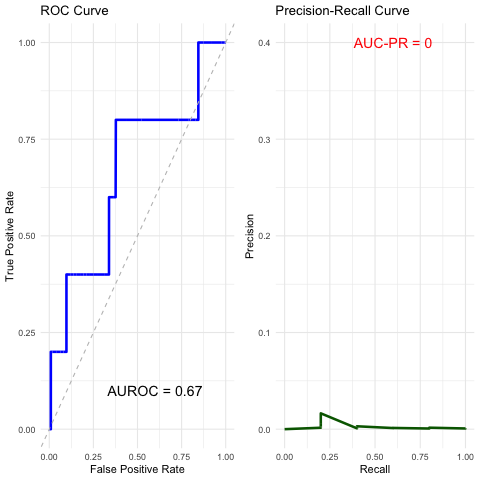

In [39]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)

# Show all plots in a grid (KM comes with table, so best shown separately)
grid.arrange(p1, p2, nrow=1)  # ROC and PR side-by-side

In [40]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)

optimal_threshold = r['optimal_threshold'][0]

print(df_validation_risk.actual_event.value_counts()) # Cases differ from ugica because the event needs to occur within the time frame of 5 years
df_validation_risk['high_risk_youden'] = np.where(df_validation_risk.pred_risk >= optimal_threshold, 1, 0)
pd.crosstab(df_validation_risk.actual_event, df_validation_risk.high_risk_youden)


actual_event
0.0    6837
1.0       5
Name: count, dtype: int64


high_risk_youden,0,1
actual_event,,
0.0,4257,2580
1.0,1,4


In [41]:
# Pass dataframe to R to analyze
pass_df(df_validation_risk, 'r_df_validation_risk')
df_validation_risk.head()

,time,event,pred_risk,actual_event,high_risk_youden
6,59.071869,0,0.001628,0.0,0
12,4.993840,0,0.001254,0.0,0
14,66.726899,0,0.002180,0.0,1
23,157.043121,0,0.002892,0.0,1
25,0.164271,0,0.002393,0.0,1


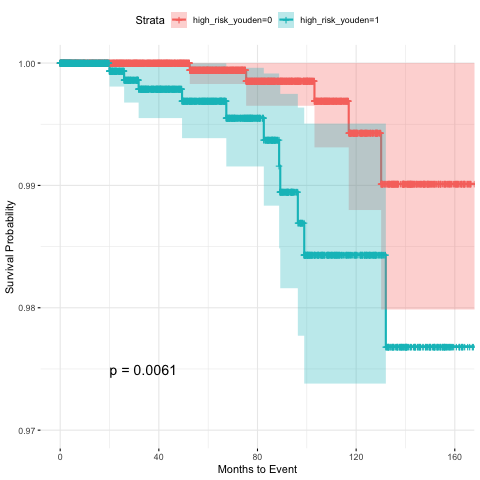

In [42]:
%%R 
surv_obj <- Surv(time = r_df_validation_risk$time, event = r_df_validation_risk$event)
fit <- survfit(surv_obj ~ high_risk_youden, data = r_df_validation_risk)

g <- ggsurvplot(
    fit,
    data = r_df_validation_risk,
    risk.table = TRUE,
    pval = TRUE,
    pval.coord = c(20, 0.975),
    conf.int = TRUE,
    xlab = "Months to Event",
    ylab = "Survival Probability",
    ylim = c(0.970, 1),
    ggtheme = theme_minimal()
)

g$plot

### Save model and threshold

In [43]:
%%R 
# Save model
saveRDS(cox_model, "coxph_escc.rds")

In [44]:
# Save optimal threshold 
import json
import os

def save_to_json(variable, filename, key=None):
    # If the file exists, load existing data
    if os.path.exists(filename):
        with open(filename, 'r') as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                data = {}
    else:
        data = {}

    # Append or update data
    if key in data:
        data[key].update(variable)
    else: 
        data[key] = variable

    # Save the updated data
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

    print(f"Saved to {filename}")


In [45]:
model = 'coxph'
subtype = 'escc'
selected_vars = list(r['selected_vars'])  

model_variables = {
    subtype: {
        "threshold": optimal_threshold,
        "variables": selected_vars
    }
}

# Save
save_to_json(model_variables, "thresholds.json", key=model)

Saved to thresholds.json
